In [1]:
"""
LangGraph Workflow 정의
게임의 전체 흐름을 그래프로 구성
"""

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from state import GameState
from nodes import (
    setup_game_node,
    character_speak_node,
    user_input_node,
    vote_node,
    next_turn_node,
    wait_for_user_node  # wait_for_user_node 함수 import
)


def should_continue_discussion(state: GameState) -> str:
    """
    대화를 계속할지 결정하는 조건부 엣지

    로직:
    1. phase가 "end"면 종료
    2. phase가 "user_turn"이면 사용자 턴 대기
    3. phase가 "discussion"이면 AI가 계속 말하기
    """
    phase = state.get("phase", "discussion")

    # 게임 종료
    if phase == "end":
        return "end"

    # 사용자가 투표를 했으면 투표 처리
    elif state.get("user_target"):
        return "vote"

    # 사용자 턴 (AI 턴이 끝남)
    elif phase == "user_turn":
        return "wait_user"

    # AI 토론 계속
    elif phase == "discussion":
        return "character_speak"

    # 기본값
    else:
        return "character_speak"


def after_user_wait(state: GameState) -> str:
    """
    사용자 대기 후 다음 동작 결정

    - user_input이 들어왔으면 user_input 노드로
    - user_target이 들어왔으면 vote 노드로
    - 아무것도 없으면 계속 대기
    """
    if state.get("user_target"):
        return "vote"
    elif state.get("user_input"):
        return "user_input"
    else:
        # 계속 대기 (실제로는 외부에서 입력을 주입할 때까지)
        return "wait_user"


def create_game_graph():
    """
    마피아 게임 그래프 생성

    플로우:
    setup → next_turn → [조건부]
                      ↓
            character_speak (AI 말하기)
                      ↓
                  next_turn
                      ↓
            wait_user (사용자 턴)
                      ↓
            user_input or vote
                      ↓
                  next_turn (다시 AI 턴으로)
    """
    # StateGraph 초기화
    workflow = StateGraph(GameState)

    # 노드 추가
    workflow.add_node("setup", setup_game_node)
    workflow.add_node("character_speak", character_speak_node)
    workflow.add_node("wait_user", wait_for_user_node)  # wait_for_user_node 함수 사용
    workflow.add_node("user_input", user_input_node)
    workflow.add_node("vote", vote_node)
    workflow.add_node("next_turn", next_turn_node)

    # 시작점: setup
    workflow.set_entry_point("setup")

    # setup 후 바로 wait_user로 (사용자 명령 대기)
    # 토큰 낭비 방지: 시작하자마자 AI가 말하지 않음
    workflow.add_edge("setup", "wait_user")

    # character_speak 후 next_turn
    workflow.add_edge("character_speak", "next_turn")

    # next_turn 후 조건부 분기
    workflow.add_conditional_edges(
        "next_turn",
        should_continue_discussion,
        {
            "character_speak": "character_speak",  # 계속 AI 턴
            "wait_user": "wait_user",              # 사용자 턴
            "vote": "vote",                        # 투표
            "end": END                             # 종료
        }
    )

    # wait_user 노드에서 사용자 입력 대기
    # (실제로는 무한 루프처럼 보이지만, 외부에서 state를 주입하면 탈출)
    workflow.add_conditional_edges(
        "wait_user",
        after_user_wait,
        {
            "user_input": "user_input",  # 일반 대화
            "vote": "vote",              # 투표
            "wait_user": "wait_user"             # 입력 대기 (그래프 일시 중단)
        }
    )

    # user_input 후 character_speak으로 (AI 토론 시작)
    workflow.add_edge("user_input", "character_speak")

    # vote 후 종료
    workflow.add_edge("vote", END)

    # 컴파일 - MemorySaver를 checkpointer로 사용
    # interrupt() 사용 시 checkpointer 필수
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)

    return app



---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	setup(setup)
	character_speak(character_speak)
	wait_user(wait_user)
	user_input(user_input)
	vote(vote)
	next_turn(next_turn)
	__end__([<p>__end__</p>]):::last
	__start__ --> setup;
	character_speak --> next_turn;
	next_turn -. &nbsp;end&nbsp; .-> __end__;
	next_turn -.-> character_speak;
	next_turn -.-> vote;
	next_turn -.-> wait_user;
	setup --> wait_user;
	user_input --> character_speak;
	wait_user -.-> user_input;
	wait_user -.-> vote;
	vote --> __end__;
	wait_user -.-> wait_user;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



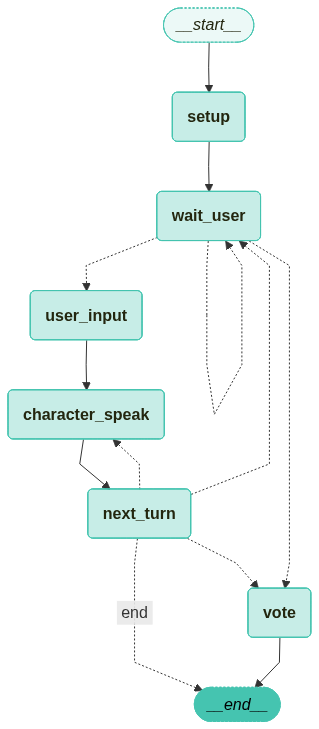

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	setup(setup)
	character_speak(character_speak)
	wait_user(wait_user)
	user_input(user_input)
	vote(vote)
	next_turn(next_turn)
	__end__([<p>__end__</p>]):::last
	__start__ --> setup;
	character_speak --> next_turn;
	next_turn -. &nbsp;end&nbsp; .-> __end__;
	next_turn -.-> character_speak;
	next_turn -.-> vote;
	next_turn -.-> wait_user;
	setup --> wait_user;
	user_input --> character_speak;
	wait_user -.-> user_input;
	wait_user -.-> vote;
	vote --> __end__;
	wait_user -.-> wait_user;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



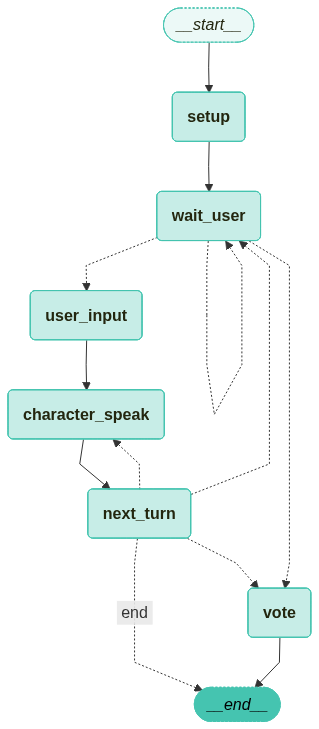

In [2]:
from langchain_teddynote.graphs import visualize_graph
# 그래프 시각화용 (선택사항)
def visualize_graph1():
    """
    그래프 구조를 시각화 (mermaid 형식)
    """
    app = create_game_graph()

    try:
        # Mermaid 다이어그램 출력
        print(app.get_graph().draw_mermaid())
        visualize_graph(app, xray=True)
        
    except Exception as e:
        print(f"시각화 실패: {e}")
        print("그래프는 정상적으로 생성되었습니다.")


if __name__ == "__main__":
    # 그래프 시각화 테스트
    visualize_graph1()

visualize_graph1()